# Machine Learning Regression problem with H2O (XGBoost & Deeplearning)

In this notebook, we will use the subset of the Freddie Mac Single-Family dataset to try to predict the interest rate for a loan using H2O's XGBoost and Deep Learning models. We will explore how to use these models for a regression problem, and we will also demonstrate how to use H2O's grid search to tune the hyper-parameters of both models.

The data set we're using comes from Freddie Mac and contains 20 years of mortgage history for each loan and contains information about "loan-level credit performance data on a portion of fully amortizing fixed-rate mortgages that Freddie Mac bought between 1999 to 2017. Features include demographic factors, monthly loan performance, credit performance including property disposition, voluntary prepayments, MI Recoveries, non-MI recoveries, expenses, current deferred UPB and due date of last paid installment."[1]

We're going to use machine learning with H2O-3 to predict the interest rate for each loan. To do this, we will build two regression models: an XGBoost model and a Deep Learning model that will help us find the interest rate that a loan should be assigned. Complete this tutorial to see how we achieved those results.

We will start by importing H2O, the estimators for the algorithms that we will use, and also the function to perform grid search on those algorithms.

In [1]:
#Import H2O and other libraries that will be used in this tutorial 
import h2o
import matplotlib as plt
%matplotlib inline

#Import the Estimators
from h2o.estimators.deeplearning import H2ODeepLearningEstimator
from h2o.estimators import H2OXGBoostEstimator

#Import h2o grid search 
import h2o.grid 
from h2o.grid.grid_search import H2OGridSearch

In [2]:
import os
import h2o

startup  = '/home/h2o/bin/aquarium_startup'
shutdown = '/home/h2o/bin/aquarium_stop'

if os.path.exists(startup):
    os.system(startup)
    local_url = 'http://localhost:54321/h2o'
    aquarium = True
else:
    local_url = 'http://localhost:54321'
    aquarium = False

In [3]:
h2o.init(url=local_url)

Checking whether there is an H2O instance running at http://localhost:54321 . connected.


H2O_cluster_uptime:,57 mins 22 secs
H2O_cluster_timezone:,America/Los_Angeles
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.30.1.1
H2O_cluster_version_age:,2 days
H2O_cluster_name:,H2O_from_python_bokhy_ughxpn
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,2.943 Gb
H2O_cluster_total_cores:,8
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


## 1. Load Data

In [4]:
#Import the dataset 
loan_level = h2o.import_file("https://s3.amazonaws.com/data.h2o.ai/DAI-Tutorials/loan_level_500k.csv")

Parse progress: |█████████████████████████████████████████████████████████| 100%


## Regression Analysis/Regressor Model
Regression tries to predict a continuous number (as different from classification, which only categorizes). With a regressor model, you try to predict the exact number from your response column. In our case, we will try to predict the interest rate. You will see later on that some samples might have a 7.5% interest rate, and our regression model will try to predict that number.

There are different types of regression analysis; for example, there is a linear regression, where you fit a straight line to your response based on your predictors, and you try to predict your output with it. Linear regressions are only advised for datasets with a linear distribution. There are also non-linear regressions, which are more useful when you do not have a linear distribution of your response variable.

For regression use cases, H2O supports the following metrics:

- R Squared (R2)
- Mean Squared Error (MSE)
- Root Mean Squared Error (RMSE)
- Root Mean Squared Logarithmic Error (RMSLE)
- Mean Absolute Error (MAE)
- In this tutorial, we'll just focus on the RMSE and MAE.

#### MSE
The MSE metric measures the average of the squares of the errors or deviations. MSE takes the distances from the points to the regression line (these distances are the "errors") and squaring them to remove any negative signs. MSE incorporates both the variance and the bias of the predictor.
MSE also gives more weight to larger differences. The bigger the error, the more it is penalized. For example, if your correct answers are 2,3,4 and the algorithm guesses 1,4,3, then the absolute error on each one is exactly 1, so squared error is also 1, and the MSE is 1. But if the algorithm guesses 2,3,6, then the errors are 0,0,2, the squared errors are 0,0,4, and the MSE is a higher 1.333.

#### RMSE
The RMSE metric evaluates how well a model can predict a continuous value. The RMSE units are the same as the predicted target, which is useful for understanding if the size of the error is of concern or not. The smaller the RMSE, the better the model's performance. RMSE is sensitive to outliers, meaning that when the error is larger, the more it is penalized.

#### MAE
The MAE is an average of the absolute errors. The MAE units are the same as the predicted target as well as the RMSW, which is also useful for understanding whether the size of the error is of concern or not. The smaller the MAE, the better the model's performance. MAE is robust to outliers, meaning all errors are penalized equally.

#### Look at the data

In [6]:
loan_level.head()

CREDIT_SCORE,FIRST_PAYMENT_DATE,FIRST_TIME_HOMEBUYER_FLAG,MATURITY_DATE,METROPOLITAN_STATISTICAL_AREA,MORTGAGE_INSURANCE_PERCENTAGE,NUMBER_OF_UNITS,OCCUPANCY_STATUS,ORIGINAL_COMBINED_LOAN_TO_VALUE,ORIGINAL_DEBT_TO_INCOME_RATIO,ORIGINAL_UPB,ORIGINAL_LOAN_TO_VALUE,ORIGINAL_INTEREST_RATE,CHANNEL,PREPAYMENT_PENALTY_MORTGAGE_FLAG,PRODUCT_TYPE,PROPERTY_STATE,PROPERTY_TYPE,POSTAL_CODE,LOAN_SEQUENCE_NUMBER,LOAN_PURPOSE,ORIGINAL_LOAN_TERM,NUMBER_OF_BORROWERS,SELLER_NAME,SERVICER_NAME,PREPAID,DELINQUENT
669,200206,N,202901,nan,0,1,O,80,33,162000,80,7.12,R,N,FRM,WV,SF,26100,F199Q1000004,P,320,2,Other sellers,Other servicers,TRUE,FALSE
732,199904,N,202903,17140,0,1,O,25,10,53000,25,6.5,R,N,FRM,OH,SF,45200,F199Q1000005,N,360,1,Other sellers,Other servicers,TRUE,FALSE
679,200208,N,202902,15940,30,1,O,91,48,133000,91,6.75,R,N,FRM,OH,SF,44700,F199Q1000007,P,319,1,Other sellers,Other servicers,TRUE,FALSE
721,200209,N,202902,38060,0,1,O,39,13,174000,39,6.625,T,N,FRM,AZ,SF,85200,F199Q1000013,N,318,2,Other sellers,Other servicers,TRUE,FALSE
618,200210,N,202902,10420,25,1,O,85,24,122000,85,6.375,R,N,FRM,OH,SF,44200,F199Q1000015,N,317,2,Other sellers,Other servicers,TRUE,FALSE
738,200211,N,202903,10420,0,1,O,73,44,218000,73,6,R,N,FRM,OH,SF,44300,F199Q1000016,P,317,2,Other sellers,Other servicers,TRUE,FALSE
761,200211,N,202904,nan,0,1,O,73,31,138000,73,6.375,R,N,FRM,SC,PU,29500,F199Q1000017,P,318,2,Other sellers,Other servicers,TRUE,FALSE
707,200211,N,202903,33340,0,1,O,60,57,136000,60,6.25,R,N,FRM,WI,SF,53000,F199Q1000018,C,317,2,Other sellers,Other servicers,TRUE,FALSE
760,200211,N,202903,33340,0,1,O,63,30,79000,63,6.125,R,N,FRM,WI,SF,53000,F199Q1000019,N,317,2,Other sellers,Other servicers,TRUE,FALSE
691,200302,N,202901,15940,0,1,O,65,25,130000,65,5.875,R,N,FRM,OH,SF,44700,F199Q1000023,P,312,2,Other sellers,Other servicers,TRUE,FALSE


In [7]:
loan_level["ORIGINAL_INTEREST_RATE"].describe()

Rows:500137
Cols:1




,ORIGINAL_INTEREST_RATE
type,real
mins,4.625
mean,7.18268686379932
maxs,11.5
sigma,0.5799408623980559
zeros,0
missing,0
0,7.12
1,6.5
2,6.75


From the description above, we can see that the maximum interest rate value is 11.5%, and the minimum is 4.625%, while the average or mean is 7.183%. Our models will have to predict a numerical value from 4.625 to 11.5 based on the predictors that we choose. Let's take a look at a more graphical representation of our data with a histogram

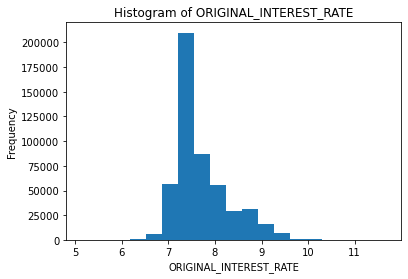

In [8]:
loan_level["ORIGINAL_INTEREST_RATE"].hist()

The histogram verifies that the interest rate around 7 and 7.5 is the most frequent one. Now that we have an idea of what our data and our response variable looks like, we can split the dataset.

**Please note that the main goal of this tutorial is to show the usage of some models for regression problems, as well as to tune some of the hyper-parameters of the models. For that reason, we will be skipping any data visualization and manipulation, as well as feature engineering. The aforementioned stages in machine learning are very important, and should always be done; however, they will be covered in later tutorials.**

We will split the dataset into three sets, training, validation, and test set. The reason for having validation and test sets is because we will use the validation set to tune our models, and we will treat the test set as some unseen data in which we will see how our models perform. We will assign 70% of our data to the training set, and 15% to both the validation and test sets.
Split the dataset and print the distribution of each set

In [9]:
train, valid, test = loan_level.split_frame([0.70, 0.15], seed=42)
print("train:%d valid:%d test:%d" % (train.nrows, valid.nrows, test.nrows))

train:350268 valid:74971 test:74898


#### Set Variables

In [10]:
y = "ORIGINAL_INTEREST_RATE"

ignore = ["ORIGINAL_INTEREST_RATE", 
          "FIRST_PAYMENT_DATE", 
          "MATURITY_DATE", 
          "MORTGAGE_INSURANCE_PERCENTAGE", 
          "PREPAYMENT_PENALTY_MORTGAGE_FLAG", 
          "LOAN_SEQUENCE_NUMBER", 
          "PREPAID", 
          "DELINQUENT", 
          "PRODUCT_TYPE"] 

x = list(set(train.names) - set(ignore))

In [11]:
x

['SELLER_NAME',
 'ORIGINAL_COMBINED_LOAN_TO_VALUE',
 'OCCUPANCY_STATUS',
 'PROPERTY_STATE',
 'FIRST_TIME_HOMEBUYER_FLAG',
 'NUMBER_OF_BORROWERS',
 'ORIGINAL_UPB',
 'PROPERTY_TYPE',
 'SERVICER_NAME',
 'ORIGINAL_DEBT_TO_INCOME_RATIO',
 'LOAN_PURPOSE',
 'CREDIT_SCORE',
 'ORIGINAL_LOAN_TO_VALUE',
 'POSTAL_CODE',
 'NUMBER_OF_UNITS',
 'CHANNEL',
 'ORIGINAL_LOAN_TERM',
 'METROPOLITAN_STATISTICAL_AREA']

## 2. Build an XGBoost Model

In [ ]:
xgb = H2OXGBoostEstimator(seed=42, model_id='XGBoost', nfolds=0, keep_cross_validation_predictions = False)

%time 
xgb.train(x=x, y=y, training_frame=train, validation_frame=valid)

Note: You do not need to specify the cross-validation parameters, but we want to show the parameters that you would have to change in order to enable H2O internal cross-validation. If you wanted to use the H2O cross-validation, you would have to set keep_cross_validation_predictions to True and change nfolds to 3, 5, or 10, depending on the number of folds that you want; by doing cross-validation, you no longer need a validation frame.

In [ ]:
xgb

When printing the model summary, you will see a complete summary with some of the parameters in your model (in this case, we only see the number of trees). You will see some scoring metrics on your training data, as well as on your validation data, as shown in the image above. From the report, we can see that the MAE, in fact, is lower than the RMSE, this might be due to having some of the interest rates at the far end of our range (such as interest rates as high as 10 and 11, when our mean is 7.2). The training and validation RMSE are 0.4212 and 0.4244, respectively. This means that according to the RMSE, on average, the predictions are 0.42 percent off from the actual values. While the training and validation MAE are 0.3071 and 0.3108 respectively, which tells us that the predictions are about 0.31 percent off from the actual values, according to the MAE. Since we have a target interest rate range between 4 to 12 percent, we will try to reduce the RMSE when tuning our models as it will penalize larger errors or outliers.

In the model summary, you will also see two tables; the first table is the scoring history, and the second one is the variable importance table (not shown here). Besides looking at the table, we can also take a look at both graphing representations of the scoring history and the variable importance.

Let's first plot the scoring histor, and variable importance

In [ ]:
xgb.plot()

In [ ]:
xgb.varimp_plot()

We will make some predictions on our validation set. To compare the predictions to the actual value, we are going to bind the two data frames, the predictions and the validation set, as follow:

In [ ]:
xgb_def_pred = xgb.predict(valid)
xgb_def_pred.cbind(valid['ORIGINAL_INTEREST_RATE'])

In the first ten predictions, we can see that they are somewhat close to the actual value, except for the first sample, which is more than 1.5% off. We can see that samples such as this one, might make the RMSE higher than the MAE.

We can also check the model performance with a test, or in this case, with a validation set, and print some of the scores for our model. For now, we will just save the model performance, as we will use later on.

In [ ]:
default_xgb_per = xgb.model_performance(valid)

## 3. Build a Deep Learning Model

Deep learning estimator is fairly easy to use. For our default Deep Learning model, we do not need to define any parameters, but we will define the seed, model id, and we will also make sure that cross-validation is disabled, as we are using a validation frame.

In [13]:
dl = H2ODeepLearningEstimator(seed=42, model_id='DL',
                              nfolds= 0,
                              keep_cross_validation_predictions = False
                              )
%time 
dl.train(x=x, y=y, training_frame=train, validation_frame=valid)

Wall time: 0 ns
deeplearning Model Build progress: |██████████████████████████████████████| 100%


In [14]:
dl

Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  DL


Status of Neuron Layers: predicting ORIGINAL_INTEREST_RATE, regression, gaussian distribution, Quadratic loss, 73,601 weights/biases, 880.4 KB, 3,598,847 training samples, mini-batch size 1


,,layer,units,type,dropout,l1,l2,mean_rate,rate_rms,momentum,mean_weight,weight_rms,mean_bias,bias_rms
0,,1,165,Input,0,,,,,,,,,
1,,2,200,Rectifier,0,0,0,0.0556208,0.213166,0,-0.0133035,0.18641,-0.016015,0.240832
2,,3,200,Rectifier,0,0,0,0.0565888,0.0597781,0,-0.055436,0.140429,0.0572095,0.523543
3,,4,1,Linear,,0,0,0.00114034,0.000922778,0,-0.00921151,0.0805816,0.53918,1.09713e-154




ModelMetricsRegression: deeplearning
** Reported on train data. **

MSE: 0.19353740345708922
RMSE: 0.43992886181414514
MAE: 0.31480976947191924
RMSLE: 0.05217880725894603
Mean Residual Deviance: 0.19353740345708922

ModelMetricsRegression: deeplearning
** Reported on validation data. **

MSE: 0.19590097755469604
RMSE: 0.4426070238424782
MAE: 0.31819382877238667
RMSLE: 0.052454661814392047
Mean Residual Deviance: 0.19590097755469604

Scoring History: 


,,timestamp,duration,training_speed,epochs,iterations,samples,training_rmse,training_deviance,training_mae,training_r2,validation_rmse,validation_deviance,validation_mae,validation_r2
0,,2020-08-12 14:53:53,0.000 sec,None,0.000000,0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,,2020-08-12 14:53:57,5.830 sec,21051 obs/sec,0.284882,1,99785.0,0.485477,0.235688,0.359848,0.282620,0.487921,0.238067,0.361016,0.286977
2,,2020-08-12 14:54:09,17.895 sec,31854 obs/sec,1.425885,5,499442.0,0.461583,0.213058,0.329545,0.351498,0.465912,0.217074,0.332636,0.349852
3,,2020-08-12 14:54:26,35.597 sec,28908 obs/sec,2.566495,9,898961.0,0.456045,0.207977,0.316504,0.366965,0.463335,0.214679,0.320577,0.357025
4,,2020-08-12 14:54:49,57.807 sec,28839 obs/sec,4.278681,15,1498685.0,0.619442,0.383708,0.489340,-0.167921,0.620816,0.385412,0.490522,-0.154329
5,,2020-08-12 14:55:03,1 min 11.748 sec,30894 obs/sec,5.705702,20,1998525.0,0.443726,0.196893,0.314879,0.400704,0.449752,0.202277,0.320370,0.394171
6,,2020-08-12 14:55:16,1 min 24.364 sec,32807 obs/sec,7.132162,25,2498168.0,0.450594,0.203035,0.318042,0.382008,0.457518,0.209322,0.322146,0.373069
7,,2020-08-12 14:55:28,1 min 36.902 sec,34270 obs/sec,8.562215,30,2999070.0,0.439929,0.193537,0.314810,0.410916,0.442607,0.195901,0.318194,0.413267
8,,2020-08-12 14:55:41,1 min 49.604 sec,35340 obs/sec,9.989340,35,3498946.0,0.457844,0.209621,0.328640,0.361962,0.463597,0.214922,0.332610,0.356297
9,,2020-08-12 14:55:45,1 min 53.112 sec,35525 obs/sec,10.274553,36,3598847.0,0.447597,0.200343,0.308114,0.390201,0.453395,0.205567,0.312505,0.384317



Variable Importances: 


,variable,relative_importance,scaled_importance,percentage
0,SELLER_NAME.Other sellers,1.000000,1.000000,0.011794
1,"SELLER_NAME.NORWESTMORTGAGE,INC",0.990678,0.990678,0.011684
2,SELLER_NAME.FIRST UNION CAPITAL,0.950101,0.950101,0.011206
3,SELLER_NAME.WELLSFARGOHOMEMORTGA,0.882134,0.882134,0.010404
4,SELLER_NAME.CHASEMANHATTANMTGECO,0.882006,0.882006,0.010402
5,SELLER_NAME.CROSSLANDMTGECORP,0.846646,0.846646,0.009985
6,SELLER_NAME.STANDARD FEDERAL BAN,0.831295,0.831295,0.009804
7,"SELLER_NAME.BANKOFAMERICA,NA",0.824306,0.824306,0.009722
8,SELLER_NAME.BISHOPSGATERESIDENTI,0.823274,0.823274,0.009710
9,"SELLER_NAME.FIRSTARBANK,NA",0.813628,0.813628,0.009596



See the whole table with table.as_data_frame()


For our deep learning model, we see that our validation scores are higher than the training scores, but not by much. The training and validation RMSE are 0.4395 and 0.4480, respectively. And the training and validation MAE are 0.3240 and 0.3298, respectively. You can also see the scoring history and variable importance table. You can plot both the scoring history and variable importance plot.

Note: The default number of epochs for a Deep Learning model is 10. We will try to find a number of epochs that will give us a better score when we tune our model.

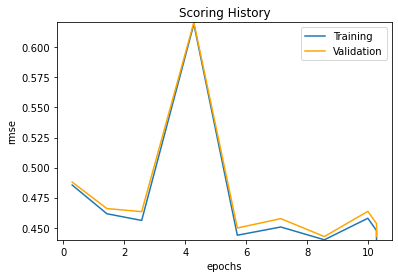

In [15]:
dl.plot()

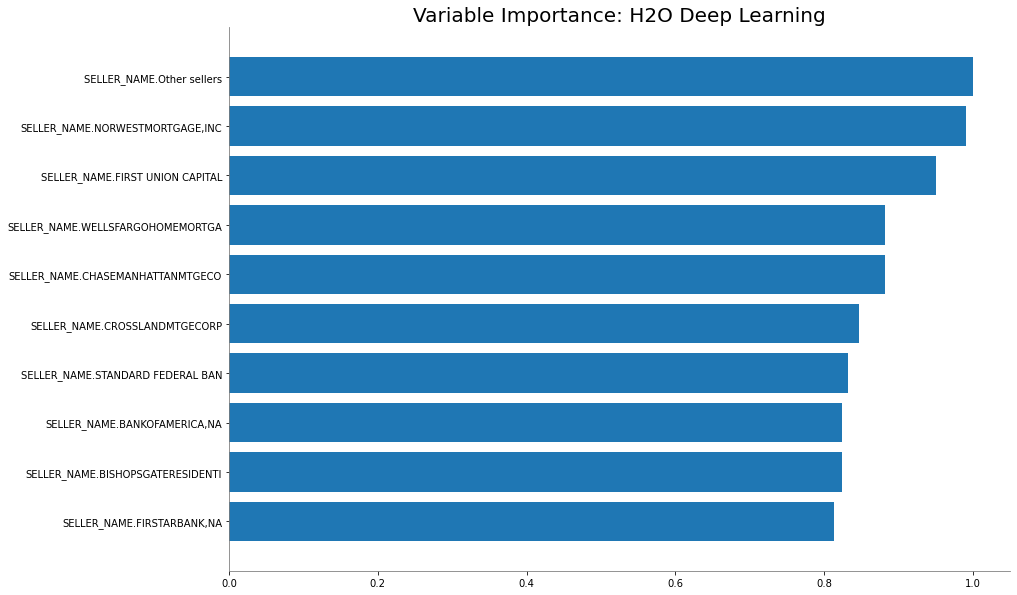

In [16]:
dl.varimp_plot()

As we can see in the image above, the variable importance plot changes a lot compared to the XGBoost. For our Deep Learning model, we see most of the SELLER_NAME variables, and the most important variable for our Deep Learning model "Other sellers" is not even included in the top ten for the XGBoost. Also, the top 10 most important variables for the Deep Learning model have almost the same significance, as opposed to the other model.

Save the model performance on the validation set, as we will use it later on for comparison purposes.

In [17]:
default_dl_per = dl.model_performance(valid)

In [18]:
default_dl_per


ModelMetricsRegression: deeplearning
** Reported on test data. **

MSE: 0.19590097755469604
RMSE: 0.4426070238424782
MAE: 0.31819382877238667
RMSLE: 0.052454661814392047
Mean Residual Deviance: 0.19590097755469604


## 4. Tune the XGBoost Model with H2O GridSearch

We will first try to find the max_depth for our XGBoost, as this is one of the most important parameters for an XGBoost model.

max_depth defines the number of nodes along the longest path from the start of the tree to the farthest leaf node. By default, the value is 6. We could do a random search along with the other parameters, but when max_depth is large, the model takes longer to train; therefore, in order to do a more efficient random search with the other parameters, we will first find the best value max_depth, and we will use 100 trees with early stopping to tune our hyper-parameters.

In [ ]:
xgb = H2OXGBoostEstimator(model_id='xgb', ntrees=100,
                          stopping_rounds=5, #default
                          stopping_tolerance=1e-4, #default
                          stopping_metric = "rmse", #default
                          seed=42
    )

hyper_params = {'max_depth' : [5,7,9,10,12,13,15,20]
               }

grid_id = 'depth_grid'

search_criteria = { "strategy":"Cartesian"}

xgb_grid = H2OGridSearch(model=xgb, 
                         hyper_params=hyper_params,
                         grid_id=grid_id,
                         search_criteria=search_criteria
                         )

In [ ]:
%time 
xgb_grid.train(x=x, y=y, training_frame=train, validation_frame = valid)

Then, we can get the models trained by the GridSearch with the .get_grid() function, and print it in a nice table format with **.sorted_metric_table()** function.

In [ ]:
sorted_xgb = xgb_grid.get_grid(sort_by='rmse',decreasing=False)
sorted_xgb.sorted_metric_table()

We will use max_depth equal to 9 to try to tune the next parameters. We will keep the same number of trees, at ntrees=100. We will start by searching over five parameters, and see if we get any improvement. Here is the list of the five parameters that we will tune.

1. reg_alpha: Specify a value for L1 regularization. L1 regularization encourages sparsity, meaning it will make the weights at the leaves become 0. This value defaults to 0.

2. reg_lambda: Specify a value for L2 regularization. L2 Regularization makes some of the weights at the leaves to be small, but not zero. This defaults to 1.

3. learn_rate (alias: eta): Specify the learning rate by which to shrink the feature weights. Shrinking feature weights after each boosting step makes the boosting process more conservative and prevents overfitting. The range is 0.0 to 1.0. This value defaults to 0.3.

4. distribution: Specify the distribution (i.e., the loss function). The options are AUTO, Bernoulli, multinomial, gaussian, poisson, gamma, or tweedie. Since our response is numeric, we will just include poisson, Tweedie, Gaussian, and gamma.

5. booster: Specify the booster type. This can be one of the following: "gbtree," "gblinear," or "dart." Note that "gbtree" and "dart" use a tree-based model while "gblinear" uses a linear function. This value defaults to "gbtree."

Since we have several parameters, we will be doing a random search; we will be using early stopping, and for our stopping criteria, we will set a limit of 100 models or 15 minutes. You can change these settings in the "search_criteria_tune" parameter for the grid search.

In [ ]:
xgb = H2OXGBoostEstimator(model_id='xgb_grid', max_depth=9, ntrees=100, 
                          stopping_rounds=5, #default
                          stopping_tolerance=1e-4, #default
                          stopping_metric = "rmse", #default
                          seed=42
                          )

hyper_params = {'reg_alpha' : [x*0.01 for x in range(0, 101)],
                'reg_lambda' : [x*0.01 for x in range(0, 101)],
                'learn_rate' : [x*0.01 for x in range(1, 101)],
                'distribution' : ['poisson', 'tweedie', 'gaussian','gamma'],
                'booster' : ['gbtree','gblinear','dart']
               }

search_criteria_tune = {'strategy': "RandomDiscrete",
                   'max_runtime_secs': 900, #15 min  
                   'max_models': 100,  ## build no more than 100 models
                   'seed' : 42 }

xgb_grid = H2OGridSearch(xgb, hyper_params,
                         grid_id = 'random_grid',
                         search_criteria=search_criteria_tune,
                         )

In [ ]:
%time 
xgb_grid.train(x=x, y=y, training_frame=train, validation_frame = valid)

The parameters for the best model in the grid search are shown in the image below:

In [ ]:
sorted_xgb = xgb_grid.get_grid(sort_by='rmse',decreasing=False)
sorted_xgb.sorted_metric_table()

With the grid search that we just did allowed us to train a total of 41 models (not all the models are shown). As you can see, the top model has a gbtree booster with a gaussian distribution, and the second-best model also has a gbtree booster with a tweedie distribution. We can also see that the next two models with the dart booster yield good scores. Since the dart booster configuration yields good results, we will try to tune some extra parameters for the third model, which uses the dart booster. Dart booster is a "method to add dropout techniques from the deep neural net community to boosted trees" [1]. We could further tune the best model from the above grid search, and to do so, we could try tuning the sample_rate,col_sample_rate,col_sample_rate_per_tree,min_rows and gamma among others. However, we want to show you the Dart functionality of XGBoost.

These are five extra parameters that we can tune when using Dart boosting, and we will try to see if we can get any improvement by changing some of those parameters

1. normalize_type: specify whether the normalization method. This can be one of the following:

- tree (default): New trees have the same weight as each of the dropped trees 1 / (k + learning_rate).
- forest: New trees have the same weight as the sum of the dropped trees (1 / (1 + learning_rate).

2. one_drop: specify whether to enable one drop, which causes at least one tree to always drop during the dropout. This value defaults to FALSE.

3. rate_drop: specify a float value from 0 to 1 for the rate at which to drop previous trees during dropout. This value defaults to 0.0.

4. sample_type: specify whether the sampling type should be one of the following:

- uniform (default): Dropped trees are selected uniformly.
- weighted: Dropped trees are selected in proportion to weight.

5. skip_drop: specify a float value from 0 to 1 for the skip drop. This determines the probability of skipping the dropout procedure during a boosting iteration. If a dropout is skipped, new trees are added in the same manner as "gbtree." Note that non-zero skip_drop has a higher priority than rate_drop or one_drop. This value defaults to 0.0.

We will update the parameters that we found in our previous grid search, and to save some time, we will set normalize_type='forest',one_drop=False, and sample_type='uniform'. We will do a quick search for rate_drop and skip_drop. Based on results from previous experiments, combinations of lowrate_drop with highskip_drop yielded slightly better results, so we will do that for this grid search. Because this is the third grid search you can skip this step, and use the values that we find.

In [ ]:
xgb = H2OXGBoostEstimator(model_id='xgb', 
                          max_depth=9, 
                          ntrees=100, 
                          distribution='gamma',
                          reg_alpha= 0.4,
                          reg_lambda= 0.1,
                          learn_rate= 0.33,
                          stopping_rounds=5, #default
                          stopping_tolerance=1e-4, #default
                          stopping_metric = "rmse", #default
                          seed=42,
                          booster = 'dart',
                          normalize_type='forest',
                          one_drop=False,
                          sample_type='uniform'
                          )

hyper_params = { 'rate_drop' : [x*0.025 for x in range(0, 21)], #start from 0 to 0.5 in increments of 0.025
                 'skip_drop' : [x*0.025 for x in range(20, 41)] #start from 0.5 to 1 in increments of 0.025
               }

search_criteria_tune = {'strategy': "RandomDiscrete",
                   'max_runtime_secs': 600, #10 min  
                   'max_models': 100,  # build no more than 100 models
                   'seed' : 42
                       }

xgb_grid = H2OGridSearch(xgb, hyper_params,
                         grid_id = 'dart_booster_grid',
                         search_criteria=search_criteria_tune,
                         )

In [ ]:
%time 
xgb_grid.train(x=x, y=y, training_frame=train, validation_frame = valid)

Now let's get the models from the grid search.

In [ ]:
sorted_xgb = xgb_grid.get_grid(sort_by='rmse',decreasing=False)
sorted_xgb.sorted_metric_table()

The score slightly improved from what we obtained in the first random grid search; keep in mind that we are just exploring a small set of models; if we were trying to find the best model, we would have to add a wider range for each parameter and run the grid search for a longer period of time. We could also do a local search with the values we found and see if we could get better results. Let's do a quick random grid search for our XGBoost in Flow.

Start by building an XGBoost model the same way we did in Task 4. Find the training set (the frame with 350k rows and 27 columns), assign a model id such flow-xgb-grid so that it is easy to find the models later on; for now, you can set
nfolds to 3. Choose ORIGINAL_INTEREST_RATE for the response_column, select the same eight columns as before to be ignored.

- FIRST_PAYMENT_DATE,
- MATURITY_DATE,
- MORTGAGE_INSURANCE_PERCENTAGE,
- PREPAYMENT_PENALTY_MORTGAGE_FLAG,
- PRODUCT_TYPE,
- LOAN_SEQUENCE_NUMBER,
- PREPAID,
- DELINQUENT

Let's retrieve the best model from the grid search and then compare the results from the default model to the tuned model.

In [ ]:
best_xgb_model = xgb_grid.models[0] 
best_xgb_model

Please note that you can also retrieve any of your models by changing the number inside the brackets. Now save the model performance on the validation set.

In [ ]:
tuned_xgb_per = best_xgb_model.model_performance(valid)

##### Check both RMSE and MAE

In [ ]:
print("Default XGB RMSE: %.4f \nTuned XGB RMSE:%.4f" % (default_xgb_per.rmse(), tuned_xgb_per.rmse()))

In [ ]:
print("Default XGB MAE: %.4f \nTuned XGB MAE:%.4f" % (default_xgb_per.mae(), tuned_xgb_per.mae()))

Both RMSE and MAE slightly improved with the tuning that we did. As we mentioned before, we only let each random search run for 15 minutes. To see if we can obtain a much better model, we would have to let it run for much longer.

One more thing that we could do is build an XGBoost model with all the parameters that we found, and increase the number of trees, similar to what we did in the first tutorial.

Maybe for an interest rate decision, an MAE of 0.30 is good enough as it tells us that, on average, the model would predict a very close interest rate to what someone with "x" characteristics would get. However, for some companies that MAE might be too high, so it all depends on the application to decide whether or not our MAE results are satisfactory. We will see if the Deep Learning model can yield a lower RMSE and MAE.

## 5. Tune the Deeplearning Model with H2O GridSearch

We will try to tune our Deep Learning model and see if we can improve the scores from the default model.

Two of the most important parameters of a Deep Learning model are the number of neurons in the hidden layers and the number of epochs. The parameter for both hidden neurons and layers is "hidden", and we can specify the hidden layer sizes. For example, to define a two-hidden-layer model, with 200 neurons in each layer, we would define it as [200,200]. If you wanted to have three hidden layers with 300 neurons in the first layer, 200 in the second one, and 100 in the third one, we would do it as follows [300,200,100]. The epochs allows us to specify the number of times to iterate (stream) the dataset, and this value can be a fraction. We will try to find a good size for our hidden layer, and we will take care of the number of epochs with early stopping.

Since there are so many combinations for the size of hidden layers, the easiest thing to do is to just do a random search and use one of the models that you find. In this tutorial, we will try to find a good size for the hidden layer taking into consideration the time it takes to train, and then we will try to tune that model. We will explore models with up to three hidden layers for you to see, but for the purpose of this tutorial, we will not try to tune a complex model.

With the code shown below, you can do a random search to explore several sizes of hidden layers. The way we chose the number of neurons is selecting multiples of 165, which is the size of our input layer (although we do not have 165 predictors, we have predictors that have multiple categories, and they all add up to 165, and thus the number of neurons) and we also added two random sizes, 100 and 200, just to see how they perform.

In [19]:
dl = H2ODeepLearningEstimator(seed=623, model_id='DL',
                              nfolds= 0,
                              keep_cross_validation_predictions = False,
                              stopping_metric='RMSE',
                              epochs=10
                              )

hyper_params = {'hidden' : [[165], [330], [495], [100], [200], 
                            [165, 33], [165, 165], [200, 165], [330, 330], 
                            [165, 330, 165]]             
               }

search_criteria_tune = {'strategy': "Cartesian",
                       }

dl_grid = H2OGridSearch(model=dl, 
                        hyper_params=hyper_params,
                         grid_id = 'hidden_layer_grid',
                         search_criteria=search_criteria_tune
                         )

In [20]:
%time 
dl_grid.train(x=x, y=y, training_frame=train, validation_frame = valid)

Wall time: 0 ns
deeplearning Grid Build progress: |███████████████████████████████████████| 100%


In [21]:
hidden_per = dl_grid.get_grid(sort_by='rmse', decreasing=False)
hidden_per.sorted_metric_table()

,,hidden,model_ids,rmse
0,,"[200, 165]",hidden_layer_grid_model_8,0.4341071484294671
1,,[165],hidden_layer_grid_model_1,0.43439024000085696
2,,"[165, 33]",hidden_layer_grid_model_6,0.43507784102688246
3,,"[165, 330, 165]",hidden_layer_grid_model_10,0.43740278087118734
4,,"[165, 165]",hidden_layer_grid_model_7,0.43750844915001474
5,,[200],hidden_layer_grid_model_5,0.4397165228189012
6,,[495],hidden_layer_grid_model_3,0.4458597302592869
7,,[330],hidden_layer_grid_model_2,0.44999944542552284
8,,"[330, 330]",hidden_layer_grid_model_9,0.45161253741728424
9,,[100],hidden_layer_grid_model_4,0.47344688626506826


Model with 165 neurons was one of the most consistent ones, so we chose one hidden layer with 165 neurons to tune the other parameters.
For deep learning models, the more complex the model, the longer it will take to train. For that reason, in this tutorial, we explore a fairly simple model, with only one hidden layer with 165 neurons.

For the activation function, we could use the rectifier activation function, as it is one of the best amongst the three activation functions in H2O. We could try the maxout activation function, but the model usually takes much longer to build. H2O gives us the option to add dropout ratios to our activation functions, and for that reason, we will use the rectifier_with_dropout activation function. Therefore, we need to find a good dropout rate for our hidden layer.

hidden_dropout_ratios improves generalization, which could help our model perform better. The range is >= 0 to <1, and the default is 0.5.

In [22]:
dl = H2ODeepLearningEstimator(
    epochs=10,
    hidden=[165],
    seed=42,
    model_id='DL',
    activation='rectifier_with_dropout'
    )

hyper_params = {'hidden_dropout_ratios' : [[0], [0.01], [0.1], [0.15], [0.25], [0.3], [0.2],
                                           [0.35],[0.5], [0.6], [0.8]]
                                            
    }

search_criteria_tune = {'strategy': "Cartesian"
                }

dl_grid = H2OGridSearch(model=dl, 
                         hyper_params=hyper_params,
                         grid_id = 'dropout_grid',
                         search_criteria=search_criteria_tune,
                         )

In [23]:
%time 
dl_grid.train(x=x, y=y, training_frame=train, validation_frame = valid)

Wall time: 0 ns
deeplearning Grid Build progress: |███████████████████████████████████████| 100%


In [24]:
dropout = dl_grid.get_grid(sort_by='rmse', decreasing=False)
dropout.sorted_metric_table()

,,hidden_dropout_ratios,model_ids,rmse
0,,[0.6],dropout_grid_model_10,0.4356616951678924
1,,[0.5],dropout_grid_model_9,0.43621413719586943
2,,[0.15],dropout_grid_model_4,0.4368963938555745
3,,[0.3],dropout_grid_model_6,0.43798861598244315
4,,[0.2],dropout_grid_model_7,0.4397494239154581
5,,[0.25],dropout_grid_model_5,0.44038035525401653
6,,[0.8],dropout_grid_model_11,0.4423341348749736
7,,[0.0],dropout_grid_model_1,0.4424075548395576
8,,[0.35],dropout_grid_model_8,0.4513440269002026
9,,[0.1],dropout_grid_model_3,0.4537795786037289


Based on our grid search, the best value for the hidden_dropout_ratios is 0.3, so for the next grid searches, we will use that value.

Another parameter that is important in deep learning models is the learning rate. H2O offers a parameter called adaptive_rate(ADADELTA) and is enabled by default. Enabling the adaptive learning rate is roughly equivalent to turning on momentum training (as each model coefficient keeps track of its history), it is only slightly more computationally expensive (it uses an approximate square-root function that only costs a few clock cycles). Also, different hyper-parameters for adaptive learning rate can affect the training speed (at least for Rectifier activation functions, where back-propagation depends on the activation values).

For cases where fastest model training is required (possibly at the expense of highest achievable accuracy), manual learning rates without momentum can be a good option, but in general, adaptive learning rate simplifies the usage of H2O Deep Learning and makes this tool highly usable by non-experts. However, let's try to disable the adaptive rate for now, and let's try to find a good learning rate for our model. For the learning rate, higher values result in a less stable model, while lower values lead to slower convergence. In order to specify the learning rate, we must disable adaptive_rate, as well as specify a value for the L2 regularization, which will add stability to our model. A suggested value for L2 is 1e-5. Please keep in mind that we could just use the adaptive learning rate feature, but we would like to show you the option to tune the parameters related to the learning rate.

We will first start by finding a good learning rate for our model.

In [25]:
dl = H2ODeepLearningEstimator(
    epochs=10,
    hidden=[165],
    seed=42,
    model_id='DL',
    activation = 'rectifier_with_dropout',
    hidden_dropout_ratios=[0.3],
    distribution='auto',
    adaptive_rate=False
    )

hyper_params = { 'rate' : [0.0001, 0.0005, 0.0008, 0.001, 0.0015, 0.0020, 0.003, 0.004, 0.007, 0.009]
                
    }

search_criteria_tune = {'strategy': "Cartesian",
                       }

dl_grid = H2OGridSearch(model=dl, hyper_params=hyper_params,
                         grid_id = 'rate_grid',
                         search_criteria=search_criteria_tune,
                         )

In [26]:
%time 
dl_grid.train(x=x, y=y, training_frame=train, validation_frame = valid)

Wall time: 0 ns
deeplearning Grid Build progress: |███████████████████████████████████████| 100%


In [27]:
learn_per = dl_grid.get_grid(sort_by='rmse', decreasing=False)
learn_per.sorted_metric_table()

,,rate,model_ids,rmse
0,,8.0E-4,rate_grid_model_3,0.433155557691245
1,,5.0E-4,rate_grid_model_2,0.43547853068737996
2,,0.001,rate_grid_model_4,0.43657606247967
3,,0.002,rate_grid_model_6,0.4370730518274487
4,,0.004,rate_grid_model_8,0.44132720783534013
5,,0.003,rate_grid_model_7,0.4430098298549247
6,,0.009,rate_grid_model_10,0.44350017657233665
7,,0.0015,rate_grid_model_5,0.44359704501530195
8,,1.0E-4,rate_grid_model_1,0.44385568648565144
9,,0.007,rate_grid_model_9,0.44390107834121134


The best learning rate according to our results is 0.0015. Now that we found a good learning rate, we need to tune some parameters that are related to the learning rate. We will try to tune five more parameters, and to do so, we will do a random search with them and see if our model is improved. Below is a short description of the parameters we are going to tune.

1. rate_annealing: Learning rate annealing reduces the learning rate to "freeze" into local minima in the optimization landscape. The annealing rate is the inverse of the number of training samples it takes to cut the learning rate in half.

2. rate_decay: The learning rate decay parameter controls the change of learning rate across layers. Meaning that depending on your learning rate and the rate_decay, the learning rate for the weights connecting the input and first hidden layer will be different to the learning rate for the weights connecting the first and the second hidden layer, as for the second layer it will be a smaller value.

3. momentum_ramp: The momentum_ramp parameter controls the amount of learning for which momentum increases (assuming momentum_stable is larger than momentum_start). The ramp is measured in the number of training samples.

4. momentum_stable: The momentum_stable parameter controls the final momentum value reached after momentum_ramp training samples. The momentum used for training will remain the same for training beyond reaching that point.

5. momentum_start: The momentum_start parameter controls the amount of momentum at the beginning of training

We will run the grid search for 10 minutes and see the results of our last grid search.

In [28]:
dl = H2ODeepLearningEstimator(
    epochs=10,
    hidden=[165],
    seed=42,
    model_id='DL',
    activation = 'rectifier_with_dropout',
    hidden_dropout_ratios=[0.3],
    distribution='auto',
    adaptive_rate=False,
    l2=1e-5,
    rate=0.0015
    )

hyper_params = { 'rate_annealing' : [1e-6, 1e-7, 1e-8, 1e-5],
                'rate_decay': [1, 0.8, 0.9, 1.1, 1.2],
                'momentum_ramp' : [10000, 15000, 5000, 20000, 50000, 100000],
                'momentum_stable' : [0.9, 0.95, 0.99, 0.999],
                'momentum_start' : [0.9, 0.4, 0.5, 0.7, 0.8]
    }

search_criteria_tune = {'strategy': "RandomDiscrete",
                   'max_runtime_secs': 600, #10 min  
                   'max_models': 100,  ## build no more than 100 models
                   'seed' : 42 
                       }

dl_grid = H2OGridSearch(model=dl, 
                        hyper_params=hyper_params,
                        grid_id = 'rate_random_grid',
                        search_criteria=search_criteria_tune,
                         )

In [29]:
%time 
dl_grid.train(x=x, y=y, training_frame=train, validation_frame = valid)

Wall time: 0 ns
deeplearning Grid Build progress: |███████████████████████████████████████| 100%


In [30]:
learn_per = dl_grid.get_grid(sort_by='rmse', decreasing=False)
learn_per.sorted_metric_table()

,,momentum_ramp,momentum_stable,momentum_start,rate_annealing,rate_decay,model_ids,rmse
0,,10000.0,0.99,0.5,1.0E-6,1.0,rate_random_grid_model_6,0.4301771103515655
1,,5000.0,0.999,0.7,1.0E-5,0.9,rate_random_grid_model_2,0.4304419302072751
2,,100000.0,0.99,0.5,1.0E-6,0.9,rate_random_grid_model_10,0.4320296415928409
3,,50000.0,0.999,0.8,1.0E-6,1.0,rate_random_grid_model_5,0.4333514969750732
4,,15000.0,0.99,0.5,1.0E-5,1.2,rate_random_grid_model_12,0.43338024198151337
5,,10000.0,0.95,0.4,1.0E-7,0.9,rate_random_grid_model_9,0.43497180119109613
6,,5000.0,0.9,0.5,1.0E-6,0.9,rate_random_grid_model_8,0.4356958871262241
7,,10000.0,0.95,0.9,1.0E-5,0.8,rate_random_grid_model_1,0.43607634668201295
8,,10000.0,0.9,0.9,1.0E-5,1.2,rate_random_grid_model_11,0.4361884657454211
9,,100000.0,0.999,0.9,1.0E-7,0.8,rate_random_grid_model_4,0.43699592947680355


From the list above, you can retrieve the parameters from the best model. In our case, the best model was the 17th model that was built, or model_id = rate_random_grid_model_17. We can see that the RMSE value slightly improved with the grid search that we just did. If you recall, at the beginning of the tutorial, we mentioned that H2O's DNN model allows you to do checkpointing. The checkpoint option allows you to specify a model key associated with a previously trained model. This will build a new model as a continuation of a previously generated model. Since we were training our model with only 10 epochs, let's now train the same model with 200 epochs while using early stopping to see if we get better results. Also, set reproducible=True, this model will take longer to train, but it will yield similar results when you run it.

To be able to use checkpointing, we need to retrieve the model from the grid search that we did, and then use the model id to continue training the same model. There are several parameters that can not be changed, and for that reason, we need to specify them one more time; however, this guarantees us that we are training the same model from the grid search, and is not a new model. 

In [39]:
best_dl_model = dl_grid.models[0]

dl_checkpoint = H2ODeepLearningEstimator(checkpoint=best_dl_model.model_id,
    epochs=200,
    hidden=[165],
    seed=42,
    model_id='DL_checkpoint',
    activation = 'rectifier_with_dropout',
    hidden_dropout_ratios=[0.3],
    distribution='auto',
    adaptive_rate=False,
    l2=1e-5,
    rate=0.0015,
    momentum_ramp=10000.0,
    momentum_stable=0.99,
    momentum_start=0.5,
    rate_annealing=1.0e-6,
    rate_decay=1.0,
    reproducible=True,                                     
                                         
    stopping_metric='RMSE',
    stopping_tolerance=0.0005,
    stopping_rounds=5
    )

In [40]:
%time 
dl_checkpoint.train(x=x, y=y, training_frame=train, validation_frame=valid)

Wall time: 0 ns
deeplearning Model Build progress: |██████████████████████████████████████| 100%


Please note that we need to specify the parameters that we tuned, because if we don't, H2O assigns the default values, and most of the parameters that we tuned can not be changed when we do a checkpoint. Print the model summary by typing the name of your model in a new cell and running it, as shown in the image below.

In [41]:
dl_checkpoint

Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  DL_checkpoint


Status of Neuron Layers: predicting ORIGINAL_INTEREST_RATE, regression, gaussian distribution, Quadratic loss, 27,556 weights/biases, 228.2 KB, 13,406,351 training samples, mini-batch size 1


,,layer,units,type,dropout,l1,l2,mean_rate,rate_rms,momentum,mean_weight,weight_rms,mean_bias,bias_rms
0,,1,165,Input,0,,,,,,,,,
1,,2,165,RectifierDropout,30,0,1e-05,0.000104121,0,0.99,-0.0126665,0.106814,0.222765,0.100227
2,,3,1,Linear,,0,1e-05,0.000104121,0,0.99,0.0917103,0.347631,-0.0538511,1.09713e-154




ModelMetricsRegression: deeplearning
** Reported on train data. **

MSE: 0.16911364387429423
RMSE: 0.4112342931642426
MAE: 0.2978915073004836
RMSLE: 0.04879573205664998
Mean Residual Deviance: 0.16911364387429423

ModelMetricsRegression: deeplearning
** Reported on validation data. **

MSE: 0.17369076195434607
RMSE: 0.4167622367181869
MAE: 0.3025638227638908
RMSLE: 0.04940479384357021
Mean Residual Deviance: 0.17369076195434607

Scoring History: 


,,timestamp,duration,training_speed,epochs,iterations,samples,training_rmse,training_deviance,training_mae,training_r2,validation_rmse,validation_deviance,validation_mae,validation_r2
0,,2020-08-12 15:34:49,0.000 sec,None,0.000000,0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,,2020-08-12 15:34:50,3 min 59.691 sec,66479 obs/sec,0.284882,1,99785.0,0.473595,0.224292,0.344861,0.317307,0.475430,0.226034,0.347454,0.323018
2,,2020-08-12 15:34:55,4 min 4.864 sec,80620 obs/sec,1.425885,5,499442.0,0.479125,0.229561,0.349255,0.301269,0.481767,0.232099,0.351324,0.304851
3,,2020-08-12 15:35:01,4 min 10.414 sec,88837 obs/sec,2.852801,10,999245.0,0.434289,0.188607,0.315483,0.425924,0.438293,0.192101,0.318645,0.424649
4,,2020-08-12 15:35:06,4 min 15.709 sec,93504 obs/sec,4.278681,15,1498685.0,0.436966,0.190939,0.311575,0.418824,0.441851,0.195233,0.314874,0.415269
5,,2020-08-12 15:35:12,4 min 21.793 sec,97294 obs/sec,5.990696,21,2098349.0,0.460790,0.212328,0.317598,0.353723,0.465161,0.216374,0.320481,0.351948
6,,2020-08-12 15:35:18,4 min 27.735 sec,99815 obs/sec,7.704435,27,2698617.0,0.483816,0.234078,0.377289,0.287520,0.482648,0.232949,0.377641,0.302306
7,,2020-08-12 15:35:23,4 min 32.789 sec,101184 obs/sec,9.133138,32,3199046.0,0.435031,0.189252,0.309273,0.423961,0.440107,0.193694,0.312866,0.419877
8,,2020-08-12 15:35:27,4 min 36.866 sec,102196 obs/sec,10.274553,36,3598847.0,0.427385,0.182658,0.307923,0.444032,0.430177,0.185052,0.310515,0.445759
9,,2020-08-12 16:15:25,4 min 49.789 sec,83747 obs/sec,11.274553,37,3949115.0,0.416845,0.173760,0.303457,0.471114,0.420429,0.176761,0.306785,0.470593



See the whole table with table.as_data_frame()

Variable Importances: 


,variable,relative_importance,scaled_importance,percentage
0,"SELLER_NAME.NORWESTMORTGAGE,INC",1.000000,1.000000,0.014304
1,SELLER_NAME.CROSSLANDMTGECORP,0.912073,0.912073,0.013046
2,CHANNEL.R,0.856126,0.856126,0.012246
3,SELLER_NAME.PNCMTGECORPOFAMERICA,0.833582,0.833582,0.011923
4,SELLER_NAME.COUNTRYWIDE,0.824922,0.824922,0.011800
5,SELLER_NAME.OLDKENTMTGECO,0.824168,0.824168,0.011789
6,SELLER_NAME.FIRST UNION CAPITAL,0.737920,0.737920,0.010555
7,"SERVICER_NAME.ABNAMROMTGEGROUP,INC",0.719728,0.719728,0.010295
8,"SELLER_NAME.FLAGSTARBANK,FSB",0.709444,0.709444,0.010148
9,SELLER_NAME.Other sellers,0.700602,0.700602,0.010021



See the whole table with table.as_data_frame()


As you can see in the image above, the RMSE and MAE slightly decreased, meaning that by increasing the number of epochs, we were able to improve the performance of our model.

You can also tune a Deep Learning model in Flow, and you would do it in the same way we did with the XGBoost. Give it a try on your own, using the parameters that we found, do a local search with them. For example, since we found the rate to be 0.0015, you could do a grid search where you use the values 0.0010; 0.0012; 0.0017; 0.0019;
Try to do the same with some of the other parameters that we found and see if you can get better results. Once you are done with Flow, go back to your Jupyter Notebook.

Let's see how our default model performance compares to the tuned one.

In [42]:
tuned_dl_per = dl_checkpoint.model_performance(valid)

In [43]:
tuned_dl_per


ModelMetricsRegression: deeplearning
** Reported on test data. **

MSE: 0.17369076195434607
RMSE: 0.4167622367181869
MAE: 0.3025638227638908
RMSLE: 0.04940479384357021
Mean Residual Deviance: 0.17369076195434607


##### Check both RMSE and MAE

In [44]:
print("Default DL Model RMSE: %.4f \nTuned DL Model RMSE:%.4f" % (default_dl_per.rmse(), tuned_dl_per.rmse()))

Default DL Model RMSE: 0.4426 
Tuned DL Model RMSE:0.4168


In [45]:
print("Default DL Model MAE: %.4f \nTuned DL Model MAE:%.4f" % (default_dl_per.mae(), tuned_dl_per.mae()))

Default DL Model MAE: 0.3182 
Tuned DL Model MAE:0.3026


As we can see, both scores improved with the grid searches that we did. In fact, our deep learning model had the greatest improvement out of the two models we tuned; however, the XGBoost still performed slightly better than the Deep Learning model.

We will now see how our models perform on the test set.

## 6. Evaludate Test Set Performance

Now that we have done some tuning for our models, we will see how the models would perform on unseen data. Let's first print the final RMSE for both models. To do so, we need to evaluate the performance of our models on the test set.

In [46]:
dl_test_per = dl_checkpoint.model_performance(test)

In [ ]:
xgb_test_per = best_xgb_model.model_performance(test)

##### Check both RMSE and MAE

In [48]:
print("nDeep Learning model Test MAE: %.4f " % 
      (dl_test_per.mae()))

nDeep Learning model Test MAE: 0.3036 


In [52]:
print("Deep Learning Model Test RMSE: %.4f " % 
      (dl_test_per.rmse()))

Deep Learning Model Test RMSE: 0.4195 


In [ ]:
print("XGBoost Test RMSE: %.4f  \nDeep Learning Model Test RMSE: %.4f " % 
      (xgb_test_per.rmse(), dl_test_per.rmse()))

The test RMSE for both models is very close to the validation results, which means that our validation set cross-validation approach worked well. As we mentioned before, the RMSE score adds more penalty to larger errors. Based on the RMSE, on average, the tuned models' predictions on the test set are about 0.41 off.

In terms of test MAE, we see that the predictions of the interest rate are 0.3 off from the actual values, which is a good indication that the model is making good predictions for the interest rate. Let's see some of the predictions for both models.

##### We will take a look at the first ten predictions of both models, compared to the actual interest value.

In [ ]:
xgb_tuned_pred = best_xgb_model.predict(test) #get predictions from xgboost
test_rate_pred=test['ORIGINAL_INTEREST_RATE'].cbind(xgb_tuned_pred)#combined xgb predictions with actual interest rate

In [54]:
dl_tuned_pred = dl_checkpoint.predict(test)#get predictions from Deep Learning Model
test_rate_pred=test['ORIGINAL_INTEREST_RATE'].cbind(dl_tuned_pred)#combined deeplearning predictions with actual interest rate
test_rate_pred.cbind(dl_tuned_pred)

deeplearning prediction progress: |███████████████████████████████████████| 100%


ORIGINAL_INTEREST_RATE,predict,predict0
6,6.53058,6.53058
6,6.17022,6.17022
7.25,6.97823,6.97823
7.125,7.03079,7.03079
7.125,7.17262,7.17262
7.75,7.03528,7.03528
6.99,6.79611,6.79611
7.125,7.18585,7.18585
7.25,7.04871,7.04871
7.125,6.88045,6.88045


Please note that the predict column has the predictions for the XGBoost model, and the predict0 column has the predictions for the Deep Learning model. As we can see in the image above, both predictions are close to the actual values. Although there might be some predictions that might be very off, the RMSE and MAE proved to us that both models make good predictions.

## 7. Shutdown the cluster

In [55]:
h2o.cluster().shutdown()

H2O session _sid_88f3 closed.
